In [8]:
import pandas as pd 
import numpy as np
from scipy.optimize import minimize 
#SLSQP, COBYLA allow constraints, therefore we use it mostly 
from functools import partial 
import matplotlib.pyplot as plt


# ------------------------------------ parameter ------------------------------------ 
# (0, 1) means long-only, since weighting of each stock are bounded to be in [0, 1].
# If you allow short selling, set lb=-1000, ub=1000. Although the Efficient frontier would be smooth
# Because in real life you cannot take such high leverage
lb = 0.0 #0.0 lower bound of the wrighting of each stock
ub = 1.0 #1.0  upper bound of the wrighting of each stock

# use weekly or monthly return for mean-variance analysis
useWeekly = False
alpha = 0.1
riskMeasure = 'vol' #vol, VaR, CVaR


## objective function = variance of portfolio, goal is to find the minimum variance portfolio for each specified target mean
## The optimize function should be put in the first parameter
## !! First param always the variable target parameter
## !! params after it always in same order as input to function
def MV(w, cov_mat):
    return np.dot(w, np.dot(cov_mat,w.T))

In [9]:
#read_data - existing portfolio
data = pd.read_excel('biggestETFData.xlsx',engine = 'openpyxl',index_col = 0)
data.index = pd.to_datetime(data.index)
start = data.index[0]
end = data.index[-1]
monthend = pd.date_range(start,end,freq='BM')

if useWeekly:
    data_m = data[data.index.dayofweek ==4]
else:
    data_m = data[data.index.isin(monthend)]

data_m_ret = (data_m / data_m.shift()-1).dropna(how = 'all')

In [10]:
# n = number of stocks
n = len(data_m_ret.columns)

# instantiate volRange for storing variance
mu_step = 0.0002
muRange = np.arange(0.0055,0.013,mu_step)
volRange = np.zeros(len(muRange))

# mean return and covariance matrix
R = data_m_ret.mean()
omega = data_m_ret.cov()


In [11]:
# weighting of minimum variance portfolio with that mean return
wgt = {}

for i in range(len(muRange)):
    mu = muRange[i]
    wgt[mu] = []
    
    # initial weight = equal weight
    x_0 = np.ones(n)/n 
    
    # bounds for weighting of each stock in optimization
    bndsa = ((lb,ub),)
    for j in range(1,n):
        bndsa = bndsa +((lb,ub),)
    
    # constraint 1 --> type=equality --> sum(weightings) = 1
    # constraint 2 --> type=equality --> np.dot(w^T, R) = mu 
    consTR = ({'type':'eq','fun':lambda x:1-np.sum(x)},{'type':'eq','fun':lambda x: mu - np.dot(x,R)}) 
    
    # args: a tuple of the fixed parameters needed to completely specify the function
    # func: The objective function to be minimized.;  fun(x, *args) -> float
    # x_0: initial guess. Array of real elements of size (n,), where ‘n’ is the number of independent variables.
    # bounds: Bounds on variables. Sequence of (min, max) pairs for each element in x. None is used to specify no bound.
    w = minimize(MV, x_0, method = 'SLSQP', constraints = consTR, bounds = bndsa, args = (omega))
    
    # w.x is solution array
    # record SD of that optimal portfolio. i.e. minimal variance of portfolio with that average return
    volRange[i] = np.dot(w.x,np.dot(omega,w.x.T))**0.5
    
    # record the weightings of that optimal portfolio
    wgt[mu].extend(np.squeeze(w.x))

# efficient frontier 
EF_df = pd.DataFrame.from_dict(wgt,orient = 'columns').T

In [12]:
# save result
EF_df.to_excel('Efficient_Frontier.xlsx')
EF_df.columns = data.columns

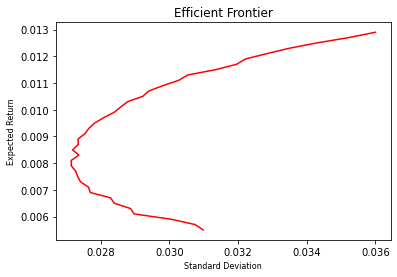

In [13]:
# plot the efficient frontier
# If weightings are bounded to be long-only [0,1], EF will not be smooth
plot1=plt.figure(1)
plt.plot(volRange,muRange,color="red")
plt.xlabel("Standard Deviation",fontsize=8)
plt.ylabel("Expected Return",fontsize=8)
plt.title("Efficient Frontier",fontsize=12)

# save fig
plt.savefig('Efficient_Frontier(NoRiskFree).png')

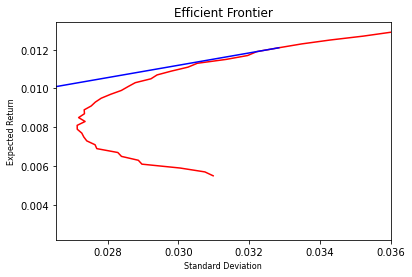

In [14]:
# risk-free rate, same period as return
rf=0.02/12
rf_weighting = np.arange(0,1,0.1)

mean_var_df = pd.DataFrame({'mean': muRange, 'sd': volRange})
mean_var_df['slope'] = (mean_var_df['mean'] - rf) / mean_var_df['sd']
tangent_portfolio = mean_var_df.loc[mean_var_df['slope'].argmax()]


plot1=plt.figure(1)
plt.plot(volRange,muRange,color="red")
plt.plot([(1-x) * tangent_portfolio['sd'] for x in rf_weighting],
         [(1-x) * tangent_portfolio['mean'] + rf * x for x in rf_weighting],
         color='blue')
plt.xlim([min(mean_var_df['sd'])-mu_step*3, max(mean_var_df['sd'])])
plt.xlabel("Standard Deviation",fontsize=8)
plt.ylabel("Expected Return",fontsize=8)
plt.title("Efficient Frontier",fontsize=12)

# save fig
plt.savefig('Efficient_Frontier(RiskFree).png')